# Liesel-GAM Demo Notebook

## Setup and Imports

In [28]:
import jax
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import liesel_gam as gam
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

from smoothcon import SmoothCon

In [29]:
from scipy import stats

rng = np.random.default_rng(1)
x = rng.uniform(-2, 2, 200)

log_sigma = -1.0 + 0.3 * (
    0.5 * x + 15 * stats.norm.pdf(2 * (x - 0.2)) - stats.norm.pdf(x + 0.4)
)
mu = -x + np.pi * np.sin(np.pi * x)
y = mu + jnp.exp(log_sigma) * rng.normal(0.0, 1.0, 200)

df = pd.DataFrame({"y": y, "x": x})

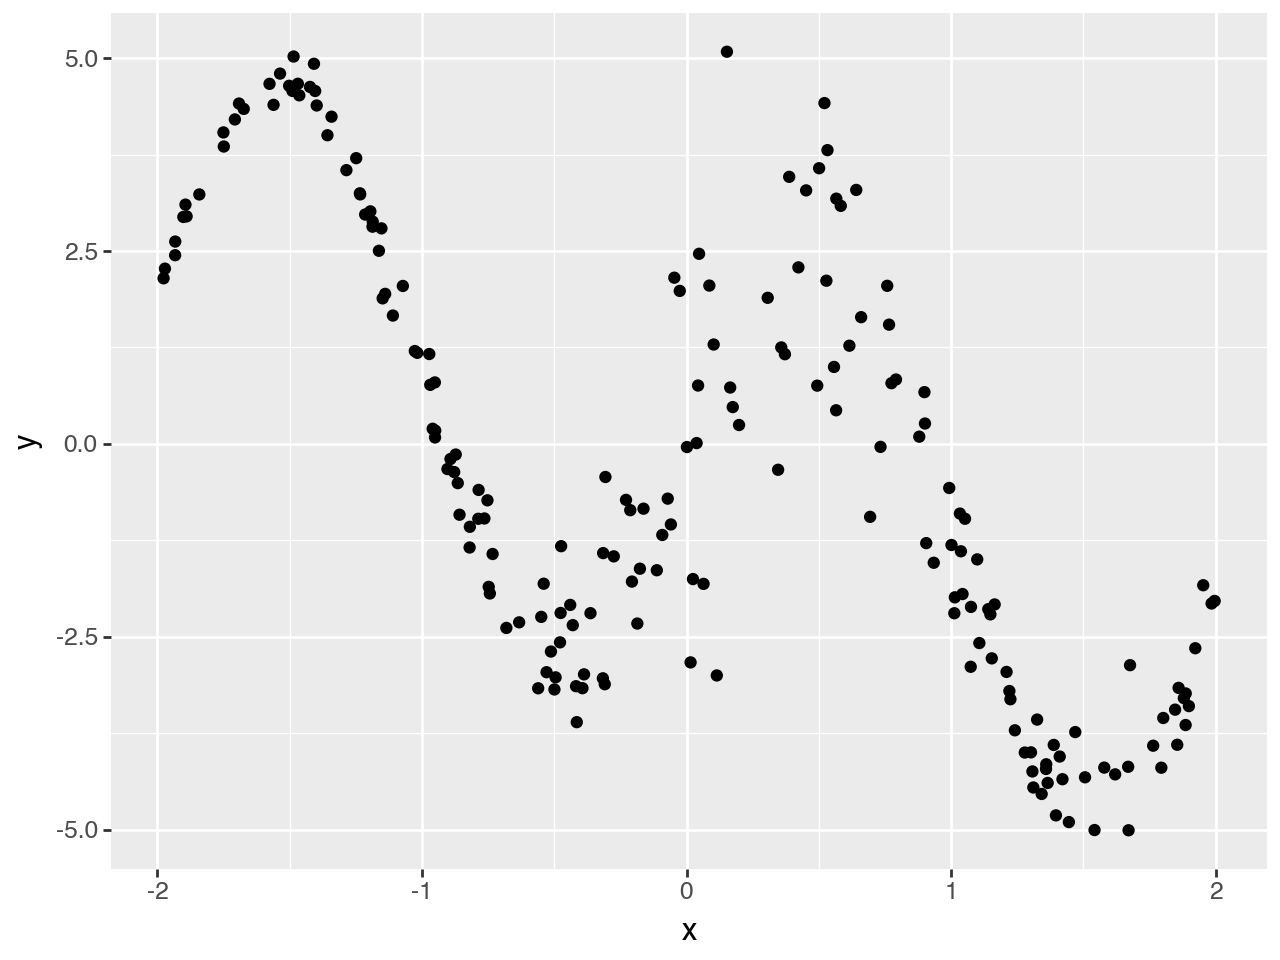

In [30]:
(p9.ggplot(df) + p9.geom_point(p9.aes("x", "y")))

## Model Definition

The `gam.AdditivePredictor()` objects are special `lsl.Var` classes. They allow users to add 
variables with the `+=` operator, and always represent the sum of all their inputs.
Thus, they conveniently represent additive predictors.

### Setup response model

In [31]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=y,
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

### Set up intercepts

In [32]:
loc += gam.Intercept(name="$\\beta_0$", inference=gs.MCMCSpec(gs.IWLSKernel))
scale += gam.Intercept(name="$\\gamma_0$", inference=gs.MCMCSpec(gs.IWLSKernel))

### Set up basis an penalty matrices

Here, we pull the basis matrix and penalty from mgcv. Note that, using the 
`SmoothCon` class, you only need to execute Python code. No manual R call and 
convesion to Python objects necessary.

In [33]:
smooth_x = SmoothCon(
    # this string is the R code you *would* call in mgcv for this term
    spec="s(x, bs='ps', k=20, m=c(3,2))",
    data=df,
)

x_basis = gam.Basis(smooth_x.basis, name="B(x)")
penalty = smooth_x.penalty

### Initialize smooth terms

The `gam.SmoothTerm` can be used to represent isotropic smooths. It is a `lsl.Var` that
will automatically initialize a fitting coefficient variabel with a 
potentially singular multivariate normal prior given the penalty matrix.

In [34]:
loc += gam.SmoothTerm.new_ig(
    basis=x_basis,
    penalty=penalty,
    ig_concentration=0.01,
    ig_scale=0.01,
    inference=gs.MCMCSpec(gs.IWLSKernel),  # New in liesel v0.4.0
    name="m(x)",
    variance_name="$\\tau^2_m$",
    coef_name="$\\beta$",  # I'm using LaTeX math syntax for pretty rendering in plots
)

scale += gam.SmoothTerm.new_ig(
    basis=x_basis,
    penalty=penalty,
    ig_concentration=0.01,
    ig_scale=0.01,
    inference=gs.MCMCSpec(gs.IWLSKernel),  # New in liesel v0.4.0
    name="s(x)",
    variance_name="$\\tau^2_s$",
    coef_name="$\\gamma$",
)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="").value
liesel.model.model - INFO - Converted dtype of Value(name="B(x)_value").value
liesel.model.model - INFO - Converted dtype of Value(name="").value


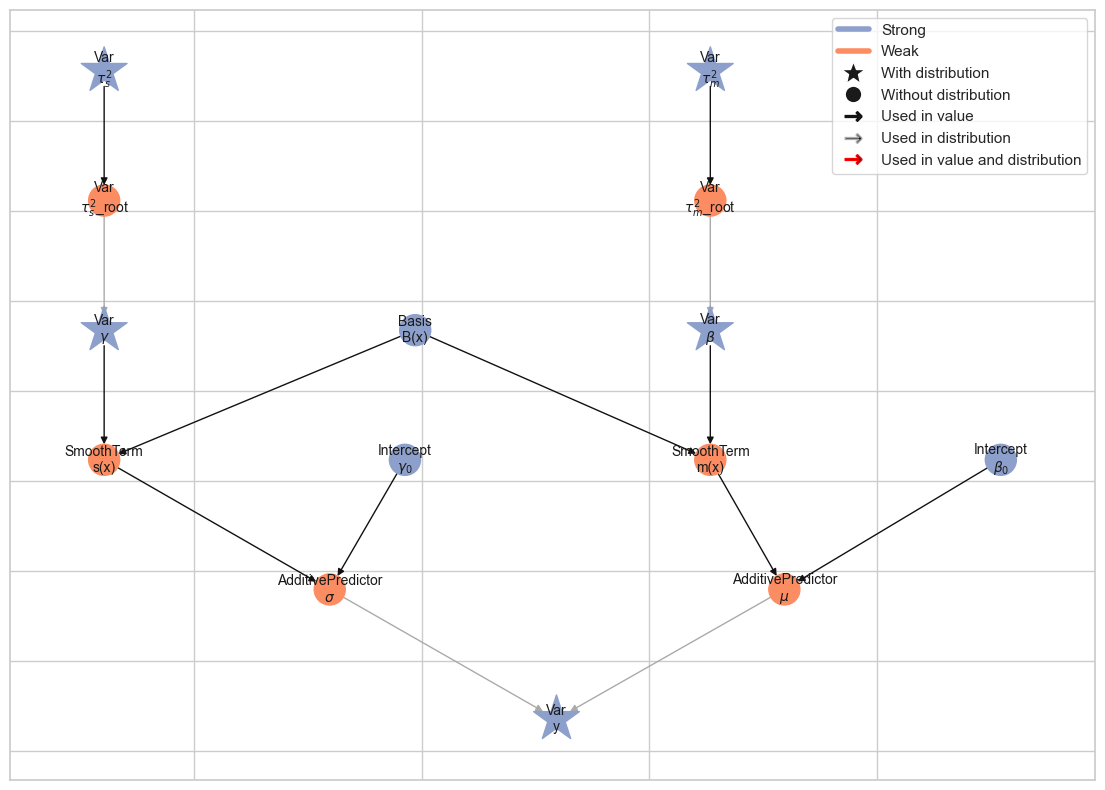

In [35]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [13]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\gamma$', '$\\tau^2_s$', '$\\gamma_0$', '$\\beta$', '$\\tau^2_m$', '$\\beta_0$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:04<00:00,  3.80chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 127.02chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 0, 0, 1, 0 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|█████████████████████████████████████████| 2/2 [00:00<00:0

### MCMC summary

In [14]:
summary = gs.Summary(results)
summary

Parameter summary:

                     kernel      mean        sd    q_0.05     q_0.5    q_0.95  \
parameter  index                                                                
$\beta$    (0,)   kernel_03  0.271258  0.449966 -0.437282  0.254675  1.039821   
           (1,)   kernel_03  0.002621  0.404667 -0.663519  0.001339  0.669951   
           (2,)   kernel_03  0.456275  0.431639 -0.196157  0.430448  1.219468   
           (3,)   kernel_03  0.191864  0.406059 -0.449792  0.181507  0.862946   
           (4,)   kernel_03  0.155329  0.369266 -0.438347  0.150969  0.775826   
           (5,)   kernel_03  0.158559  0.345510 -0.417672  0.150847  0.721637   
           (6,)   kernel_03 -0.026872  0.329686 -0.558849 -0.028835  0.511558   
           (7,)   kernel_03  0.079321  0.308965 -0.424588  0.082220  0.591588   
           (8,)   kernel_03  0.080442  0.299203 -0.382450  0.071240  0.573448   
           (9,)   kernel_03  0.121370  0.258518 -0.288280  0.117029  0.549516   
           (10,)  kernel_03  0.116211  0.250493 -0.296310  0.124569  0.511484   
           (11,)  kernel_03 -0.131616  0.210937 -0.476777 -0.131790  0.214206   
           (12,)  kernel_03  0.300826  0.188875 -0.018228  0.302695  0.600919   
           (13,)  kernel_03 -0.040044  0.146762 -0.276585 -0.040898  0.202699   
           (14,)  kernel_03  1.361104  0.114700  1.175409  1.357247  1.551879   
           (15,)  kernel_03 -0.042259  0.074062 -0.163536 -0.042695  0.078179   
           (16,)  kernel_03  0.124234  0.043347  0.055196  0.123230  0.195228   
           (17,)  kernel_03  0.015415  0.017601 -0.013703  0.015405  0.043708   
           (18,)  kernel_03 -0.309327  0.067614 -0.419049 -0.310457 -0.197396   
$\beta_0$  ()     kernel_05 -0.319472  0.060664 -0.417572 -0.320570 -0.217177   
$\gamma$   (0,)   kernel_00  0.015595  0.120648 -0.171235  0.010260  0.210383   
           (1,)   kernel_00  0.017339  0.119482 -0.165752  0.015537  0.211792   
           (2,)   kernel_00  0.003712  0.118099 -0.190108  0.005117  0.197272   
           (3,)   kernel_00  0.005815  0.114780 -0.179218  0.004967  0.194030   
           (4,)   kernel_00 -0.025844  0.118664 -0.220264 -0.021607  0.156150   
           (5,)   kernel_00  0.010318  0.112920 -0.172862  0.009648  0.191533   
           (6,)   kernel_00 -0.036034  0.116716 -0.231856 -0.031681  0.143050   
           (7,)   kernel_00  0.055711  0.112016 -0.112905  0.049422  0.245614   
           (8,)   kernel_00  0.039753  0.107159 -0.125554  0.034572  0.219998   
           (9,)   kernel_00  0.002011  0.098656 -0.161846  0.000933  0.166722   
           (10,)  kernel_00 -0.005101  0.092089 -0.153921 -0.006236  0.147293   
           (11,)  kernel_00  0.000817  0.088734 -0.143204 -0.001572  0.149434   
           (12,)  kernel_00  0.106404  0.085603 -0.023500  0.102278  0.253538   
           (13,)  kernel_00 -0.098078  0.074243 -0.225874 -0.096867  0.016458   
           (14,)  kernel_00  0.052757  0.060276 -0.045459  0.052972  0.150306   
           (15,)  kernel_00 -0.080508  0.044036 -0.151813 -0.080574 -0.008878   
           (16,)  kernel_00 -0.006271  0.026424 -0.048904 -0.006373  0.035274   
           (17,)  kernel_00 -0.044520  0.011558 -0.063290 -0.044475 -0.025284   
           (18,)  kernel_00  0.136533  0.044795  0.065137  0.136806  0.207394   
$\gamma_0$ ()     kernel_02 -0.634448  0.053370 -0.720190 -0.635576 -0.546110   
$\tau^2_m$ ()     kernel_04  0.245150  0.122898  0.111857  0.215058  0.482024   
$\tau^2_s$ ()     kernel_01  0.014004  0.011308  0.004299  0.010944  0.033560   

                  sample_size     ess_bulk     ess_tail      rhat  
parameter  index                                                   
$\beta$    (0,)          4000  3508.561557  3427.667708  1.000511  
           (1,)          4000  3421.140900  3916.027349  0.999991  
           (2,)          4000  3427.519594  3210.292547  1.000667  
           (3,)          4000  3103.449856  3551.050266  1.000822  
       

### MCMC trace plots

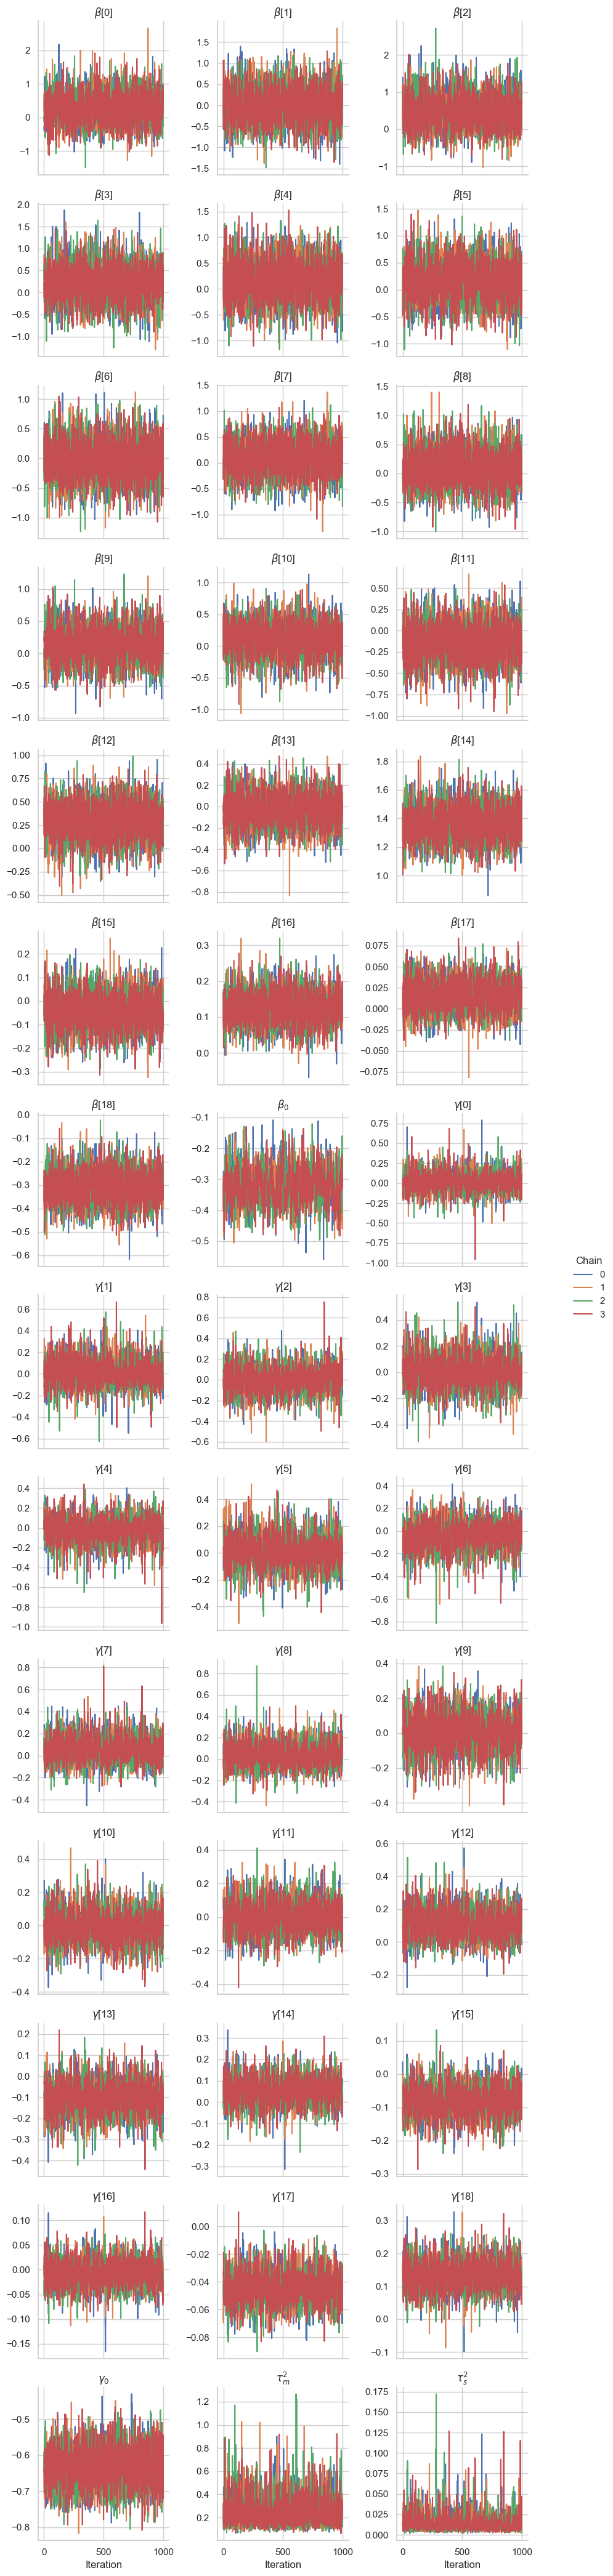

In [15]:
gs.plot_trace(results)

## Predictions

In [16]:
samples = results.get_posterior_samples()

### Evaluate basis matrix for new x values

We use the `SmoothCon` oject initialized above. This will internally call `mgcv`
to evaluate the basis matrix at the new x values, applying all the right reparameterizations 
automatically.

In [17]:
x_grid = jnp.linspace(x.min(), x.max(), 200)
B_x_grid = smooth_x.predict(data={"x": x_grid})

### Predict variables at new x values

In [40]:
predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=["m(x)", "s(x)", "$\\mu$", "$\\sigma$"],
    newdata={"B(x)": B_x_grid},
)

# TODO: validierung von doppelten keys in samples und newdata

predictions_summary = (
    gs.SamplesSummary(predictions).to_dataframe().reset_index()
)  # new in liesel v0.4.0
predictions_summary["x"] = np.tile(x_grid, len(predictions))

In [41]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,var,sd,rhat,ess_bulk,ess_tail,mcse_mean,mcse_sd,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high,x
0,$\mu$,$\mu$[0],"(0,)",4000,2.188746,0.004088,0.063936,1.000284,3552.124871,3321.710325,0.001072,0.000946,2.087594,2.187302,2.293837,2.084725,2.289886,-1.976702
1,$\mu$,$\mu$[1],"(1,)",4000,2.375386,0.002423,0.049227,1.000360,3524.711809,3378.011426,0.000830,0.000745,2.296083,2.374152,2.455615,2.295007,2.452571,-1.956738
2,$\mu$,$\mu$[2],"(2,)",4000,2.557426,0.001735,0.041659,1.000357,3389.046090,3614.626632,0.000714,0.000611,2.490408,2.557039,2.624567,2.490037,2.623578,-1.936774
3,$\mu$,$\mu$[3],"(3,)",4000,2.734512,0.001646,0.040571,1.000218,3329.599168,3898.030505,0.000701,0.000557,2.667995,2.734761,2.801208,2.672482,2.804804,-1.916810
4,$\mu$,$\mu$[4],"(4,)",4000,2.906283,0.001880,0.043358,1.000023,3346.647677,3563.764908,0.000747,0.000569,2.834474,2.907117,2.976528,2.833923,2.975878,-1.896846


### Plot fitted functions

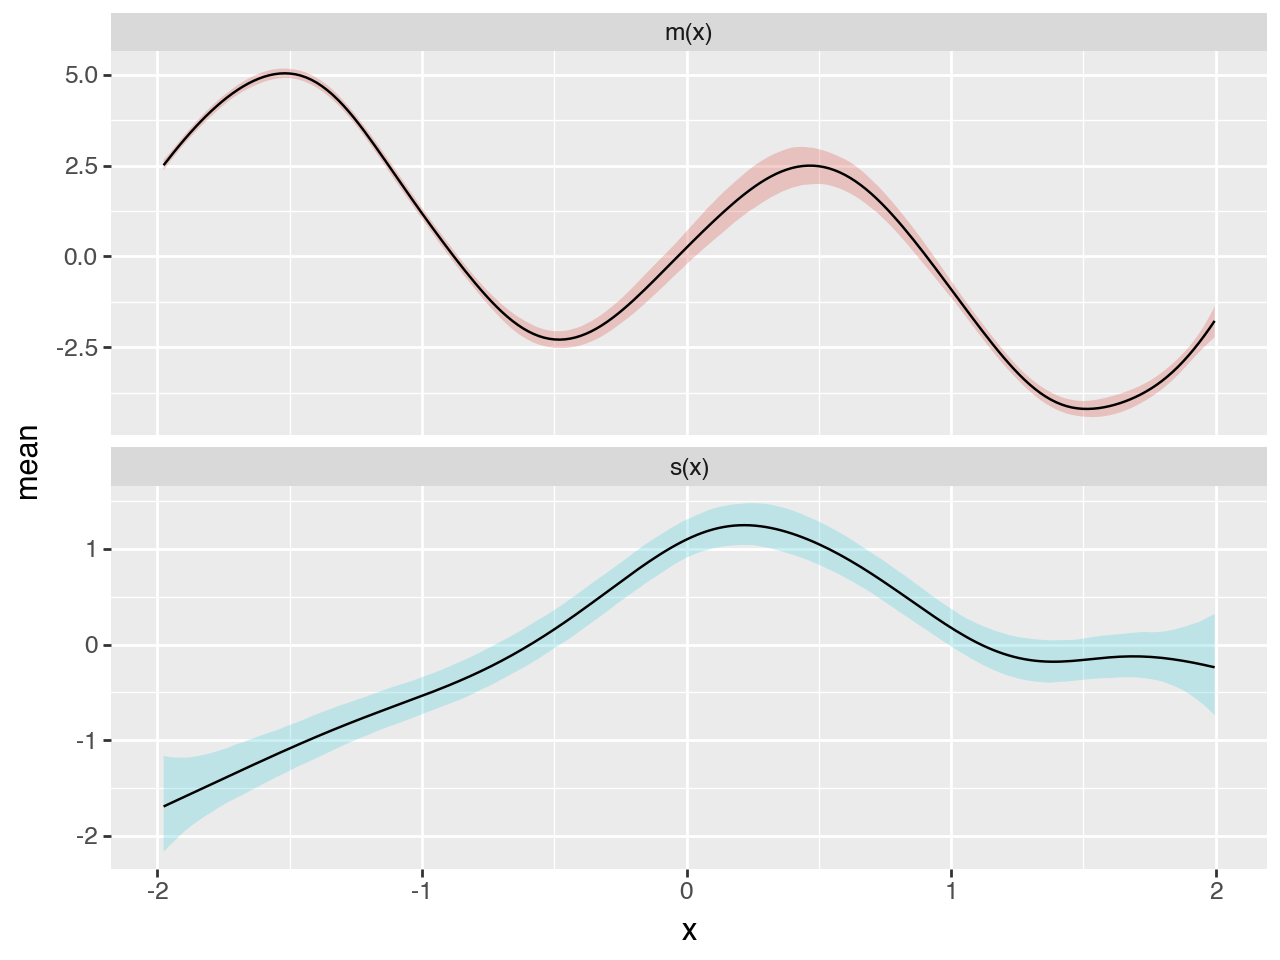

In [42]:
select = predictions_summary["variable"].isin(["s(x)", "m(x)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot parameters as functions of covariate

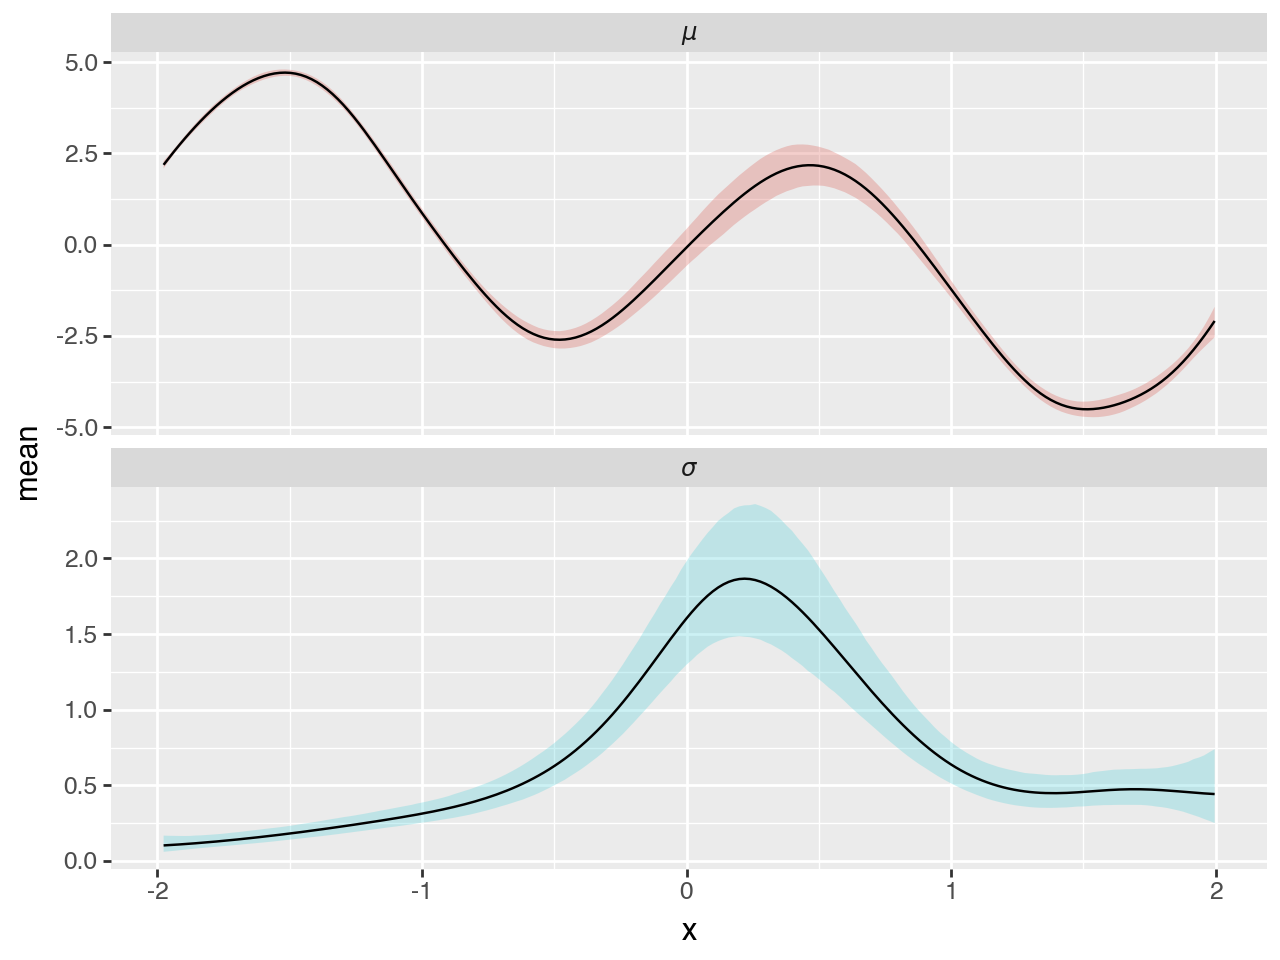

In [43]:
select = predictions_summary["variable"].isin(["$\\mu$", "$\\sigma$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot mean function with data

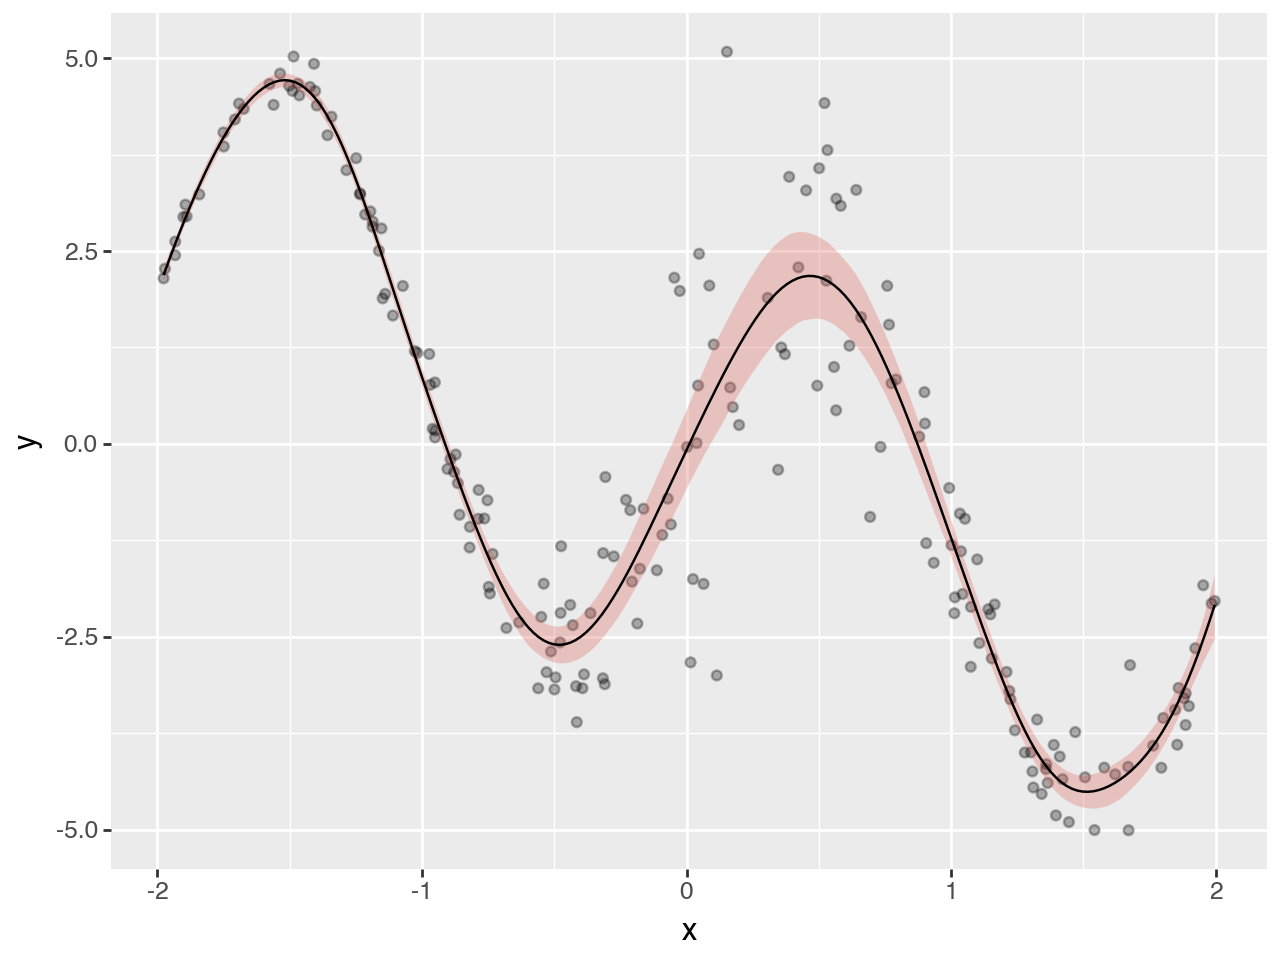

In [44]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.guides(fill="none")
)

### Plot average posterior predictive distribution

In [45]:
select = predictions_summary["variable"].isin(["$\\mu$", "$\\sigma$"])
mu_sigma_df = (
    predictions_summary[select][["variable", "mean", "x"]]
    .pivot(index="x", columns=["variable"], values="mean")
    .reset_index()
)

mu_sigma_df["low"] = mu_sigma_df["$\\mu$"] - mu_sigma_df["$\\sigma$"]
mu_sigma_df["high"] = mu_sigma_df["$\\mu$"] + mu_sigma_df["$\\sigma$"]
mu_sigma_df

variable,x,$\mu$,$\sigma$,low,high
0,-1.976702,2.188746,0.102720,2.086026,2.291467
1,-1.956738,2.375386,0.104719,2.270667,2.480106
2,-1.936774,2.557426,0.106863,2.450563,2.664289
3,-1.916810,2.734512,0.109147,2.625365,2.843658
4,-1.896846,2.906283,0.111564,2.794718,3.017847
...,...,...,...,...,...
195,1.916248,-2.878739,0.451934,-3.330672,-2.426805
196,1.936212,-2.696362,0.449171,-3.145534,-2.247190
197,1.956176,-2.503684,0.446592,-2.950276,-2.057091
198,1.976140,-2.301271,0.444275,-2.745546,-1.856996


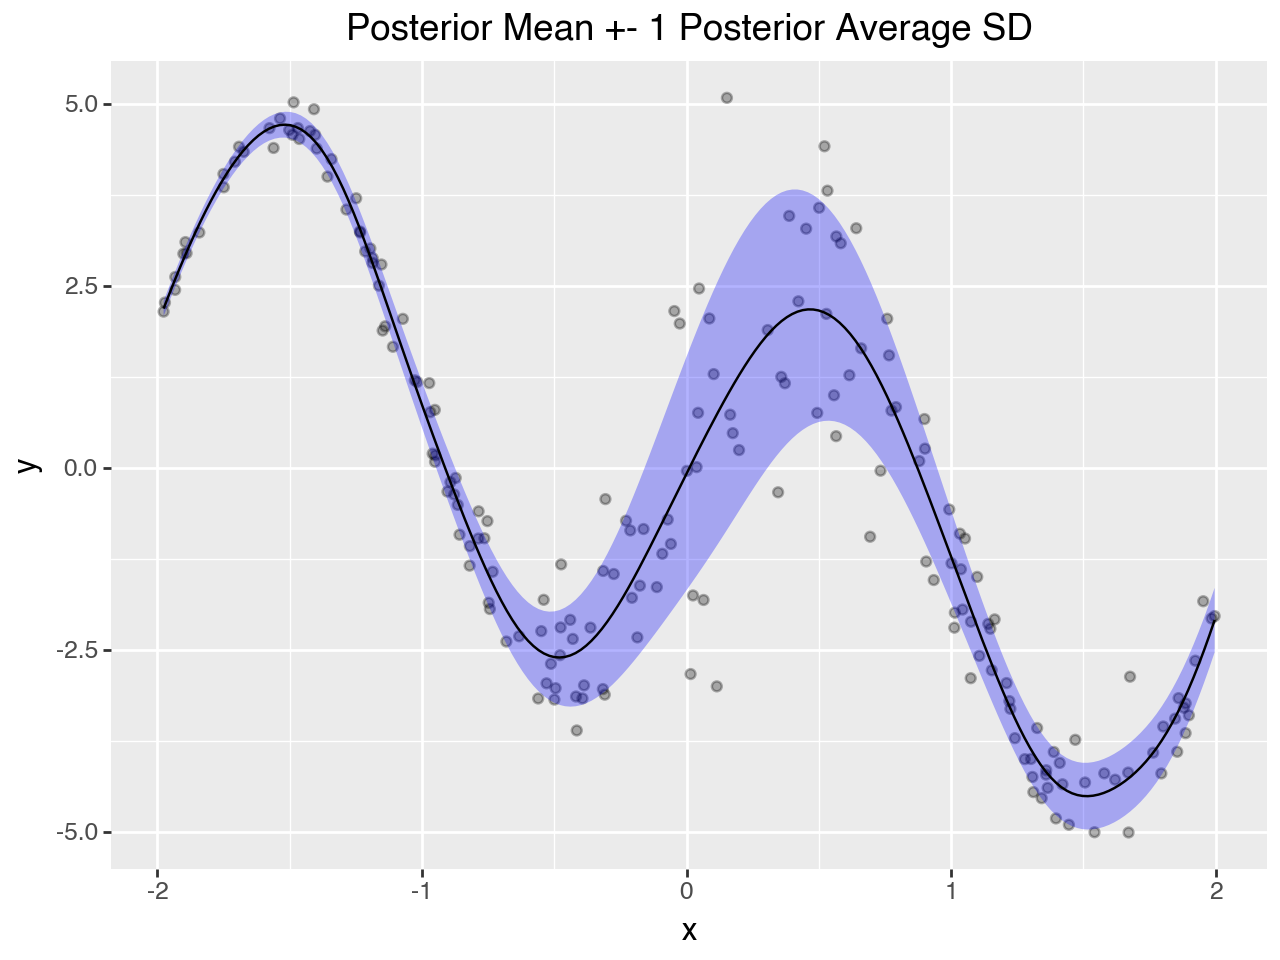

In [46]:
(
    p9.ggplot()
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="low", ymax="high"),
        alpha=0.3,
        fill="blue",
        data=mu_sigma_df,
    )
    + p9.geom_line(p9.aes("x", "$\\mu$"), data=mu_sigma_df)
    + p9.labs(title="Posterior Mean +- 1 Posterior Average SD")
    + p9.guides(fill="none")
)

## Posterior Predictive Checks

### Draw posterior predictive samples

In [47]:
ppsamples = model.sample(  # new in liesel v0.4.0
    shape=(3,), seed=jax.random.key(1), posterior_samples=samples
)

ppsamples["y"].shape

(3, 4, 1000, 200)

In [48]:
# can be reshaped to concatenate the first two axes
_ = ppsamples["y"].reshape(-1, *ppsamples["y"].shape[2:])

### Summarize posterior predictive samples

In [49]:
ppsamples = model.sample(
    shape=(),  # just draw 1 value for each posterior sample
    seed=jax.random.key(1),
    posterior_samples=samples,
)

# summarise ppsamples
ppsamples_summary = gs.SamplesSummary(ppsamples).to_dataframe().reset_index()

# add covariate to df
ppsamples_summary["x"] = df["x"].to_numpy()

### Plot posterior predictive summary

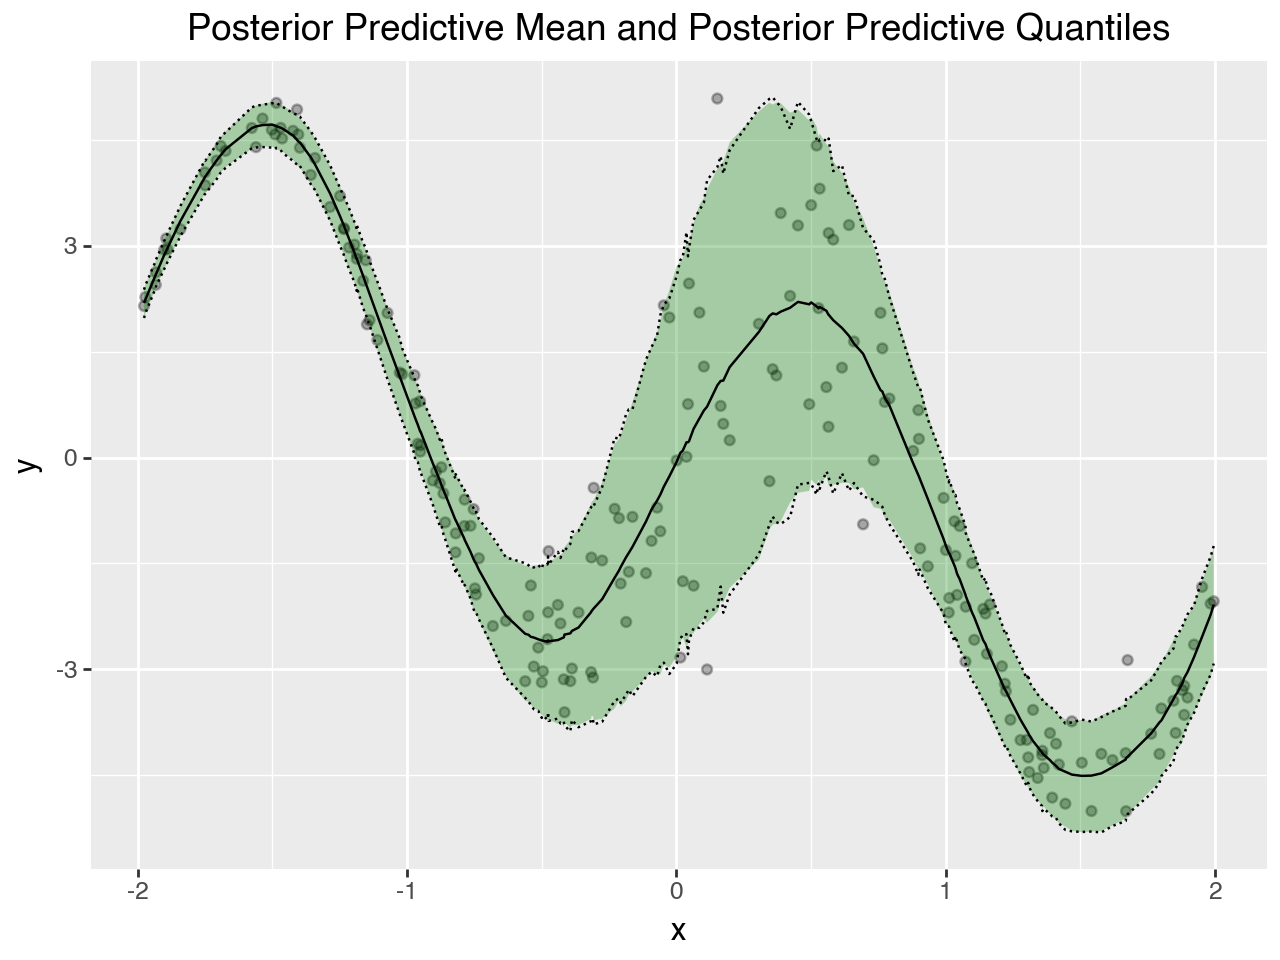

In [50]:
(
    p9.ggplot(ppsamples_summary)
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
    )
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.labs(title="Posterior Predictive Mean and Posterior Predictive Quantiles")
    + p9.guides(fill="none")
)

### Plot posterior predictive samples

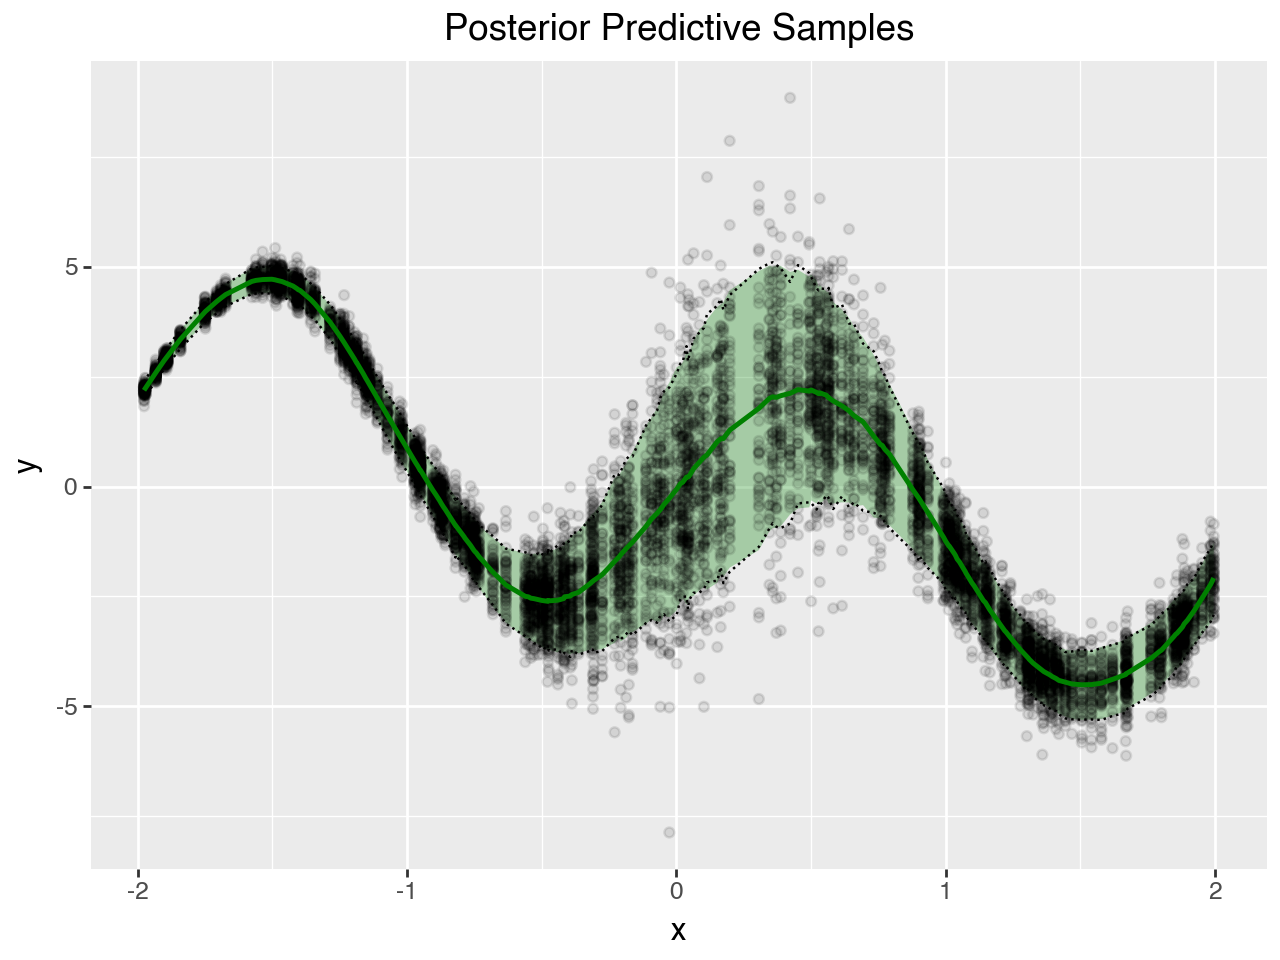

In [51]:
ppsamples_reshaped = ppsamples["y"].reshape(-1, *ppsamples["y"].shape[2:])
ppsamples_df = pd.DataFrame(ppsamples_reshaped.T)
ppsamples_df["x"] = df["x"].to_numpy()
ppsamples_df = ppsamples_df.melt(id_vars=["x"], value_name="y", var_name="sample")
ppsamples_df[ppsamples_df["sample"].isin(range(5))]


nsamples = 50


(
    p9.ggplot(ppsamples_df[ppsamples_df["sample"].isin(range(nsamples))])
    + p9.labs(title="Posterior Predictive Samples")
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
        data=ppsamples_summary,
    )
    + p9.geom_point(p9.aes("x", "y"), alpha=0.1)
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted", data=ppsamples_summary)
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted", data=ppsamples_summary)
    + p9.geom_line(p9.aes("x", "mean"), color="green", size=1, data=ppsamples_summary)
)